In [1]:
def hypergeometric_var_min(N, K, n):
    "Return the minimum value the variable can take"
    return long(n-N+K if n-N+K > 0 else 0)

In [2]:
def hypergeometric_var_max(N, K, n):
    "Return the maximum value the variable can take"
    return long(n if n < K else K)

In [3]:
import numpy
import scipy.stats
def hypergeometric_sumlargeprobabilities(N, K, n, k):
    """
    Determines how unlikely it is that given a total sample of N elements with K elements of a specific type,
    a random subsample of n elements contains k elements of the specific type.
    Returns a value between 0 and 1, where 1 indicates very unlikely and 0 very likely.
    If the subsample is truly drawn in a random way from the total sample, then this 
    hypergeometric_sumlargeprobabilities has a uniform distribution.
    """
    if n == 0 or K == 0:
        return numpy.random.uniform()
    kmin = hypergeometric_var_min(N, K, n)
    kmax = hypergeometric_var_max(N, K, n)
    sampleprobability = scipy.stats.hypergeom.pmf(k, N, K, n)
    result = sampleprobability * numpy.random.uniform()
    prob   = sampleprobability
    if (2*K == N):
        #This part is in stead of the else part because for symmetric distributions (where N = 2K)
        #the '<=' and the '<' below do not sufficiently distinguish the symmetric probabilities
        #left and right of the central value
        for i in range(k, n-k-1, +1):
            prob   = prob * float((K-i)*(n-i))/float((i+1)*(N-K-n+i+1))
            result = result + prob
        prob = sampleprobability
        for i in range(k, n-k, -1):
            prob   = prob * float((i)*(N-K-n+i))/float((n-i+1)*(K-i+1))
            result = result + prob
    else:
        for i in range(k, kmax, +1):
            prob   = prob * float((K-i)*(n-i))/float((i+1)*(N-K-n+i+1))
            if prob <= sampleprobability: break
            result = result + prob
        prob = sampleprobability
        for i in range(k, kmin, -1):
            prob   = prob * float((i)*(N-K-n+i))/float((n-i+1)*(K-i+1))
            if prob < sampleprobability: break
            result = result + prob
    return result
        

In [4]:
import numpy
import scipy.stats
def inv_hypergeometric_sumlargeprobabilities(m, M, n, N):
    """
    Determines how unlikely it is that after a first sample of N elements with n elements of a specific type,
    a second sample of M elements contains m elements of the specific type.
    Returns a value between 0 and 1, where 1 indicates very unlikely and 0 very likely.
    If the second sample is truly drawn from the same collection as the first sample, then this 
    inv_hypergeometric_sumlargeprobabilities has a uniform distribution.
    """
    sampleprobability = scipy.stats.hypergeom.pmf(m, N+M, n+m, M)
    result = sampleprobability * numpy.random.uniform()
    prob = sampleprobability
    if (2*n == N):
        #This part is in stead of the else part because for symmetric distributions (where N = 2n)
        #the '<=' and the '<' below do not sufficiently distinguish the symmetric probabilities
        #left and right of the central value
        for i in range(m, M-m-1, +1):
            prob = prob * float((n+i+1)*(M-i))/float((i+1)*(N+M-n-i))
            result = result + prob
        prob = sampleprobability
        for i in range(m, M-m, -1):
            prob = prob * float((i)*(N+M-n-i+1))/float((n+i)*(M-i+1))
            result = result + prob
    else:
        for i in range(m, M, 1):
            prob = prob * float((n+i+1)*(M-i))/float((i+1)*(N+M-n-i))
            if prob <= sampleprobability: break
            result = result + prob
        prob = sampleprobability
        for i in range(m, 0, -1):
            prob = prob * float((i)*(N+M-n-i+1))/float((n+i)*(M-i+1))
            if prob < sampleprobability: break
            result = result + prob
    return result * float(N+1)/float(N+M+1)


In [5]:
import numpy, math
def hypergeometric_quantize_2d_correlation_histo(H2D):
    """
    Takes a 2D histogram of entries (unnormalized and unweighted)
    and determines if the two variables/axes are uncorrelated,
    i.e. if the probability to get an x and y is the product of
    probabilities to get x and y separately p(x,y) = p(x)p(y).
    It does so by calculating for each bin a p-value, whether 
    entries in bin (x,y) can be expected from all entries in x 
    and all entries in y.
    Returns a 2D histogram of p-values for each bin
    """
    xaxis = H2D.sum(0)
    yaxis = H2D.sum(1)
    SOLP  = numpy.zeros(shape = H2D.shape)
    ni = H2D.shape[1]
    nj = H2D.shape[0]
    N  = int(H2D.sum())
    for i in range(0, ni):
        for j in range(0, nj):
            p = hypergeometric_sumlargeprobabilities(N, int(xaxis[i]), int(yaxis[j]), int(H2D[j][i]))
            SOLP[j][i] = p
    return SOLP

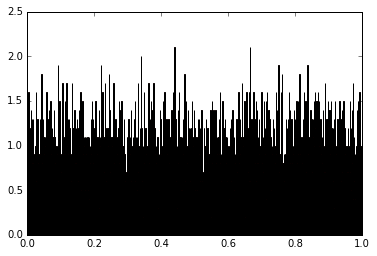

In [6]:
"Shows that the hypergeometric sum of larger probabilities (SOLP) acts as a p-value,"
"i.e. that for a random hypergeometric variable the SOLP has uniform distribution."
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
NRANDOM = 10000
N = 100
K = 10
n = 90
l = []
for i in range(0, NRANDOM):
    k = scipy.stats.hypergeom.rvs(N, K, n)
    l.append(hypergeometric_sumlargeprobabilities(N, K, n, k))
fig = plt.figure()
ax = fig.add_subplot(111)
bs = ax.hist(l, 1000, range=(0,1), normed=True, color='red')

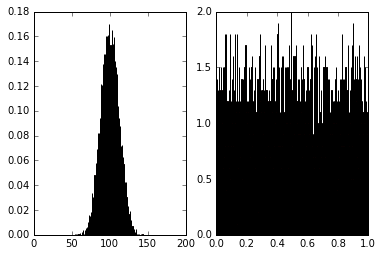

In [7]:
"Shows that the inverse hypergeometric sum of larger probabilities (SOLP) acts as a p-value,"
"i.e. that for a random inverse hypergeometric variable the SOLP has uniform distribution."
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

"Helper function that generates a random inverse hypergeometric variable"
def inv_hypergeometric_random(M, N, n):
    p = np.random.uniform()
    prob = scipy.stats.hypergeom.pmf(0, N+M, n, M) * float(N+1)/float(N+M+1)
    sumprob = prob
    for m in range(0, M, 1):
        if sumprob > p: break
        prob = prob * float((n+m+1)*(M-m))/float((m+1)*(N+M-n-m))
        sumprob += prob
    return m

"Make some plots"
NRANDOM = 10000
N = 100
n = 50
M = 200
a = []
l = []
for i in range(0, NRANDOM):
    k = inv_hypergeometric_random(M, N, n)
    a.append(k)
    l.append(inv_hypergeometric_sumlargeprobabilities(k, M, n, N))

fig = plt.figure()
ax1 = fig.add_subplot(121)
bs = ax1.hist(a, 1000, range=(0,M), normed=True, color='red')
ax2 = fig.add_subplot(122)
bs = ax2.hist(l, 1000, range=(0,1), normed=True, color='red')

The mean value for the uncorrelated histogram = 0.502694, which is 0.933098 standard deviations away from 1/2
The mean value for the correlated histogram = 0.526947, which is 9.334639 standard deviations away from 1/2


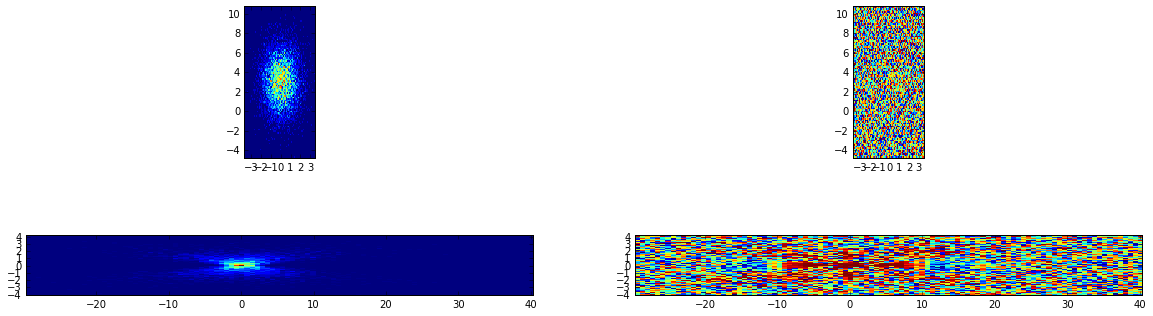

In [8]:
import matplotlib.pyplot as plt
xuncorr = numpy.random.normal(0, 1, 10000)
yuncorr = numpy.random.normal(3, 2, 10000)
xcorr = numpy.zeros(10000)
ycorr = numpy.zeros(10000)
for i in range(0, 10000):
    a = numpy.random.normal(0, 1, 1)
    ycorr[i] = a
    xcorr[i] = (numpy.random.normal(0, 1+4*abs(a), 1)) # We introduce a correlation between x and y in the width/sigma of the x-variable
H2Duncorr, xeuncorr, yeuncorr = numpy.histogram2d(xuncorr, yuncorr, bins=100)
H2Dcorr, xecorr, yecorr = numpy.histogram2d(xcorr, ycorr, bins=100)
SOLP2Duncorr = hypergeometric_quantize_2d_correlation_histo(H2Duncorr)
SOLP2Dcorr = hypergeometric_quantize_2d_correlation_histo(H2Dcorr)
extentuncorr = [xeuncorr[0], xeuncorr[-1], yeuncorr[0], yeuncorr[-1] ]
extentcorr = [xecorr[0], xecorr[-1], yecorr[0], yecorr[-1] ]
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 6))
ax1.imshow(H2Duncorr.T, interpolation='nearest', origin='lower', extent=extentuncorr)
ax2.imshow(SOLP2Duncorr.T, interpolation='nearest', origin='lower', extent=extentuncorr)
ax3.imshow(H2Dcorr.T, interpolation='nearest', origin='lower', extent=extentcorr)
ax4.imshow(SOLP2Dcorr.T, interpolation='nearest', origin='lower', extent=extentcorr)
meanuncorr = SOLP2Duncorr.mean()
meancorr = SOLP2Dcorr.mean()
print 'The mean value for the uncorrelated histogram = %f, which is %f standard deviations away from 1/2' % (meanuncorr, (meanuncorr-0.5)*math.sqrt(12*SOLP2Duncorr.size))
print 'The mean value for the correlated histogram = %f, which is %f standard deviations away from 1/2' % (meancorr, (meancorr-0.5)*math.sqrt(12*SOLP2Dcorr.size))

In [9]:
%load_ext watermark
%watermark -a KAVE -d -t -v -p numpy,pandas -g

KAVE 2016-09-01 17:27:24 

CPython 2.7.12
IPython 4.0.1

numpy 1.10.1
pandas 0.17.1
Git hash: e682a8ce36d019fff0ee6067182136550a222d07
